## CS441: Applied ML - HW 4

### Part 1: Model Complexity and Tree-based Regressors

One measure of a tree’s complexity is the maximum tree depth. Train tree, random forest, and boosted tree regressors on the temperature regression task, using all default parameters except:


*   max_depth={2,4,8,16,32}
*   random_state=0
*   For random forest: max_features=1/3

Measure train and val RMSE for each and plot them all on the same plot using the provided plot_depth_error function. You should have six lines (train/val for each model type), each with 5 data points (one for each max depth value).  Include the plot and answer the analysis questions in the report.

In [1]:
import numpy as np
# from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt

# load data (modify to match your data directory or comment)
def load_temp_data():
  # drive.mount('/content/drive')
  # datadir = "/content/drive/My Drive/CS441/24SP/hw1/"
  datadir="./"
  T = np.load(datadir + 'temperature_data.npz')
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target temperature
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()

# load data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()

In [2]:
# to plot the errors
def plot_depth_error(max_depths, tree_train_err, tree_val_err, rf_train_err, rf_val_err, bt_train_err, bt_val_err):
  plt.figure()
  plt.semilogx(max_depths, tree_train_err, 'r.--',label='tree train')
  plt.semilogx(max_depths, tree_val_err, 'r.-', label='tree val')
  plt.semilogx(max_depths, rf_train_err, 'g.--',label='RF train')
  plt.semilogx(max_depths, rf_val_err, 'g.-', label='RF val')
  plt.semilogx(max_depths, bt_train_err, 'b.--',label='BT train')
  plt.semilogx(max_depths, bt_val_err, 'b.-', label='BT val')
  plt.ylabel('RMSE Error')
  plt.xlabel('Max Tree Depth')
  plt.xticks(max_depths, max_depths)
  plt.legend()
  plt.rcParams.update({'font.size': 20})
  plt.show()

In [4]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

max_depths = [2,4,8,16,32]

# usage examples
# model = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
# model = RandomForestRegressor(random_state=0, max_depth=max_depth, max_features=1/3)
# model = GradientBoostingRegressor(random_state=0, max_depth=max_depth)

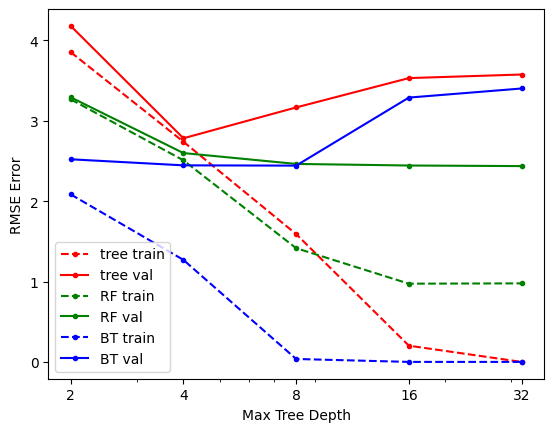

In [16]:
def rmse(a,b):
  return np.sqrt(((a - b) ** 2).mean())

tree_train_err, tree_val_err, rf_train_err, rf_val_err, bt_train_err, bt_val_err = [[] for i in range(6)]

for max_depth in max_depths:
  model = DecisionTreeRegressor(random_state=0,max_depth=max_depth)
  model.fit(x_train,y_train)
  tree_train_err.append(rmse(y_train,model.predict(x_train)))
  tree_val_err.append(rmse(y_val,model.predict(x_val)))

  model = RandomForestRegressor(random_state=0, max_depth=max_depth, max_features=1/3)
  model.fit(x_train,y_train)
  rf_train_err.append(rmse(y_train,model.predict(x_train)))
  rf_val_err.append(rmse(y_val,model.predict(x_val)))

  model = GradientBoostingRegressor(random_state=0, max_depth=max_depth)
  model.fit(x_train,y_train)
  bt_train_err.append(rmse(y_train,model.predict(x_train)))
  bt_val_err.append(rmse(y_val,model.predict(x_val)))
  

plot_depth_error(max_depths,tree_train_err, tree_val_err, rf_train_err, rf_val_err, bt_train_err, bt_val_err)

### Part 2: MLPs with MNIST

For this part, you will want to use a GPU to improve runtime. Google Colab provides limited free GPU acceleration to all users. Go to Runtime and change Runtime Type to GPU.  This will reset your compute node, so do it before starting to run other cells.

See [Tips](https://docs.google.com/document/d/1_kV9x1LCAFfe6UqY22eqj2eqdCZh72oQDf60zRo2ydM/edit?usp=drive_link) for detailed guidance on this problem.

First, use PyTorch to implement a Multilayer Perceptron network with one hidden layer (size 64) with ReLU activation. Set the network to minimize cross-entropy loss, which is the negative log probability of the training labels given the training features. This objective function takes unnormalized logits as inputs.

*Do not use MLP in sklearn for this HW - use Torch*.

In [1]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
import torch
import torch.nn as nn

def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 768-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

def display_mnist(x, subplot_rows=1, subplot_cols=1):
  '''
  Displays one or more examples in a row or a grid
  '''
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

2024-04-04 22:28:11.317892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 22:28:11.317982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 22:28:11.617690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 22:28:12.287867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 22:28:16.969390: W tensorflow/compiler/tf2

In [2]:
# Sets device to "cuda" if a GPU is available  (in Colabs, enable GPU by Edit->Notebook Settings-->Hardware Accelerator=GPU)
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device) # make sure you're using GPU instance

cuda


#### 2a
Using the train/val split provided in the starter code, train your network for 100 epochs with learning rates of 0.01, 0.1, and 1.  Use a batch size of 256 and the SGD optimizer.  After each epoch, record the mean training and validation loss and compute the validation error of the final model. The mean validation loss should be computed after the epoch is complete.  The mean training loss can either be computed after the epoch is complete, or, for efficiency, computed using the losses accumulated during the training of the epoch.  Plot the training and validation losses using the display_error_curves function.

In [3]:
(x_train, y_train), (x_test, y_test) = load_mnist()

# create train/val split
ntrain = 50000
x_val = x_train[ntrain:].copy()
y_val = y_train[ntrain:].copy()
x_train = x_train[:ntrain]
y_train = y_train[:ntrain]
x_val.shape

(10000, 784)

In [4]:
def display_error_curves(training_losses, validation_losses):
  """
  Plots the training and validation loss curves
  training_losses and validation_losses should be lists or arrays of the same length
  """
  num_epochs = len(training_losses)

  plt.plot(range(num_epochs), training_losses, label="Training Loss")
  plt.plot(range(num_epochs), validation_losses, label="Validation Loss")

  # Add in a title and axes labels
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  # Display the plot
  plt.legend(loc='best')
  plt.show()

In [5]:
# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(input_size,hidden_size)
        self.l2 = nn.Linear(hidden_size,output_size)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.l2(self.act(self.l1(x)))

In [6]:
# This is a possible function definition for training MLP, but feel free to change it
# You may also want to create helper functions, e.g. for computing loss or prediction
def train_MLP_mnist(train_loader, val_loader, lr=1e-1, num_epochs=100):
  '''
  Train a MLP
  Input: train_loader and val_loader are dataloaders for the training and
  val data, respectively. lr is the learning rate, and the network will
  be trained for num_epochs epochs.
  Output: return a trained MLP
  '''
  # TODO: fill in all code

  input_size = 784
  hidden_size = 64
  output_size = 10

  # Instantiate the model
  mlp = MLP(input_size,hidden_size,output_size)
  mlp.to(device)
  
  # Train the model, compute and store train/val loss at each epoch
  train_losses,val_losses = [],[]
  optim = torch.optim.SGD(mlp.parameters(),lr=lr)
  for e in range(num_epochs):
    print(f"Epoch: {e}")
    tloss, terr = evaluate_MLP(mlp,train_loader,optim)
    vloss, verr = evaluate_MLP(mlp,val_loader,None)
    train_losses.append(tloss)
    val_losses.append(vloss)
    print(f"Terr {terr}   verr {verr}")
    print(f"Tloss {tloss} vloss {vloss}")
    
  
  # Display Loss Curves
  display_error_curves(train_losses,val_losses)
  print(np.min(val_losses), np.argmin(val_losses))
  return mlp


def evaluate_MLP(mlp, loader, optim):
  ''' Computes loss and error rate given your mlp model and data loader'''
  N = 0
  acc = 0
  loss = 0
  loss_function = torch.nn.CrossEntropyLoss()
  with torch.set_grad_enabled(optim is not None):
    for i, data in enumerate(loader, 0):
      # print(i)
      # Get inputs
      inputs, targets = data
      N += len(targets)

      # Perform forward pass
      outputs = mlp(inputs.to(device))

      # Compute sum of correct labels
      y_pred = np.argmax(outputs.detach().cpu().numpy(), axis=1)
      y_gt = np.argmax(targets.numpy(), axis=1)
      acc += np.sum(y_pred==y_gt)

      # Compute loss
      L = loss_function(outputs, targets.to(device))
      if optim:
        optim.zero_grad()
        L.backward()
        optim.step()
      loss += L.item()*len(targets)
      

  loss /= N
  acc /= N

  return loss, 1-acc


In [7]:
# Code for running experiments

print(device) # make sure you're using GPU instance
torch.manual_seed(0) # to avoid randomness, but if you wanted to create an ensemble, you should not use a manual seed

# TODO (set up dataloaders, and call training function)
trainset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(np.eye(10)[y_train]))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=0)

valset = torch.utils.data.TensorDataset(torch.Tensor(x_val), torch.Tensor(np.eye(10)[y_val]))
val_loader = torch.utils.data.DataLoader(valset, batch_size=1000, shuffle=True, num_workers=0)

cuda


In [8]:
testset = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(np.eye(10)[y_test]))
test_loader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True, num_workers=0)

Epoch: 0
Terr 0.20704   verr 0.11240000000000006
Tloss 0.8635518909454346 vloss 0.4086389631032944
Epoch: 1
Terr 0.10518000000000005   verr 0.09040000000000004
Tloss 0.3782551777935028 vloss 0.3238971889019012
Epoch: 2
Terr 0.09284000000000003   verr 0.08650000000000002
Tloss 0.32524825715065003 vloss 0.2945525795221329
Epoch: 3
Terr 0.08440000000000003   verr 0.0746
Tloss 0.2957117403411865 vloss 0.26729006320238113
Epoch: 4
Terr 0.07718000000000003   verr 0.06840000000000002
Tloss 0.2725549217414856 vloss 0.243122835457325
Epoch: 5
Terr 0.07155999999999996   verr 0.06699999999999995
Tloss 0.25301938406944274 vloss 0.23046422004699707
Epoch: 6
Terr 0.06645999999999996   verr 0.06030000000000002
Tloss 0.23652801489830017 vloss 0.21672380119562148
Epoch: 7
Terr 0.06240000000000001   verr 0.056400000000000006
Tloss 0.22202131447076798 vloss 0.2057206466794014
Epoch: 8
Terr 0.05891999999999997   verr 0.05579999999999996
Tloss 0.20898935275554656 vloss 0.1961863398551941
Epoch: 9
Terr 0.05

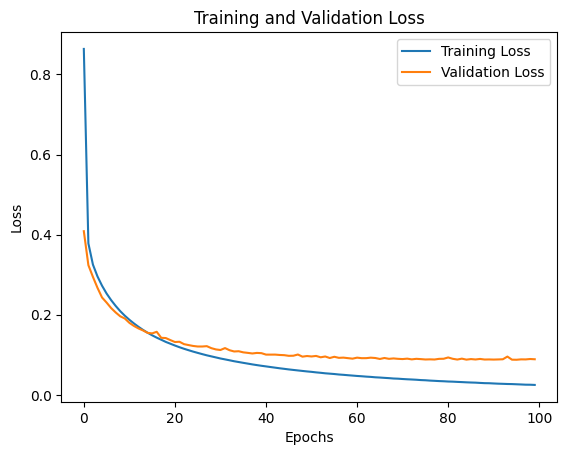

0.08776346370577812 95


In [9]:
torch.manual_seed(0)
mlp = train_MLP_mnist(train_loader,val_loader,.1)

#### 2b
Based on the loss curves, select the learning rate and number of epochs that minimizes the validation loss.  Retrain that model (if it's not stored), and report training loss, validation loss, training error, validation error, and test error.

In [12]:
N = 0
acc = 0
loss = 0
loss_function = torch.nn.CrossEntropyLoss()
with torch.set_grad_enabled(False):
  for i, data in enumerate(train_loader, 0):
    # print(i)
    # Get inputs
    inputs, targets = data
    N += len(targets)

    # Perform forward pass
    outputs = mlp(inputs.to(device))

    # Compute sum of correct labels
    y_pred = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    y_gt = np.argmax(targets.numpy(), axis=1)
    acc += np.sum(y_pred==y_gt)

    # Compute loss
    L = loss_function(outputs, targets.to(device))
    loss += L.item()*len(targets)
    

loss /= N
acc /= N

print(loss,1-acc)

0.02350550983905792 0.0040799999999999725


## Part 3: Predicting Penguin Species

Include all your code for part 3 in this section.  

In [1]:
import numpy as np
# from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
#styling preferences for sns
sns.set_style('whitegrid')
sns.set_context('poster')
# drive.mount('/content/gdrive/')
# datadir = "/content/gdrive/MyDrive/CS441/hw4/" # TO DO: modify this to your directory
datadir="./"
df_penguins = pd.read_csv(datadir + 'penguins_size.csv')
df_penguins.head(10)

# convert features with multiple string values to binary features so they can be used by sklearn
def get_penguin_xy(df_penguins):
  data = np.array(df_penguins[['island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']])
  y = df_penguins['species']
  ui = np.unique(data[:,0]) # unique island
  us = np.unique(data[:,-1]) # unique sex
  X = np.zeros((len(y), 10))
  for i in range(len(y)):
    f = 0
    for j in range(len(ui)):
      if data[i, f]==ui[j]:
        X[i, f+j] = 1
    f = f + len(ui)
    X[i, f:(f+4)] = data[i, 1:5]
    f=f+4
    for j in range(len(us)):
      if data[i, 5]==us[j]:
        X[i, f+j] = 1
  feature_names = ['island_biscoe', 'island_dream', 'island_torgersen', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex_female', 'sex_male', 'sex_unknown']
  X = pd.DataFrame(X, columns=feature_names)
  return(X, y, feature_names, np.unique(y))

/tmp/ipykernel_320/2524931758.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### 3a
Spend some time to visualize different pairs of features and their relationships to the species.  We’ve done one for you.  Include in your report at least two other visualizations.

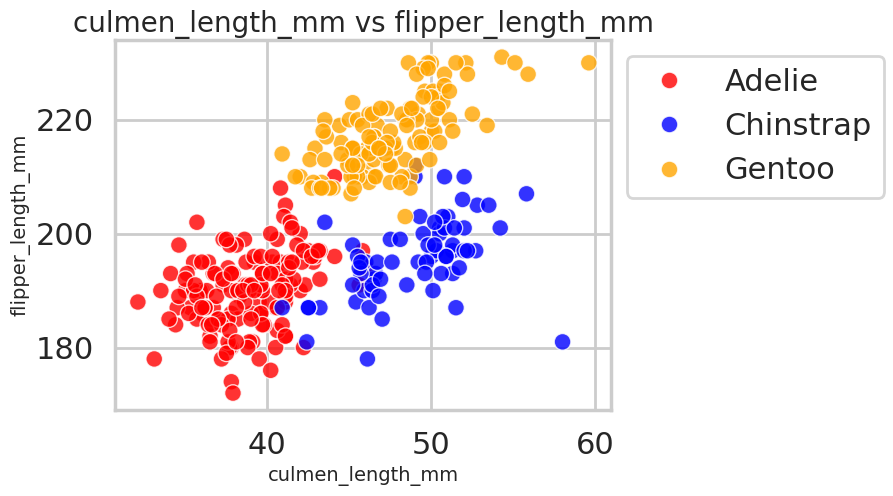

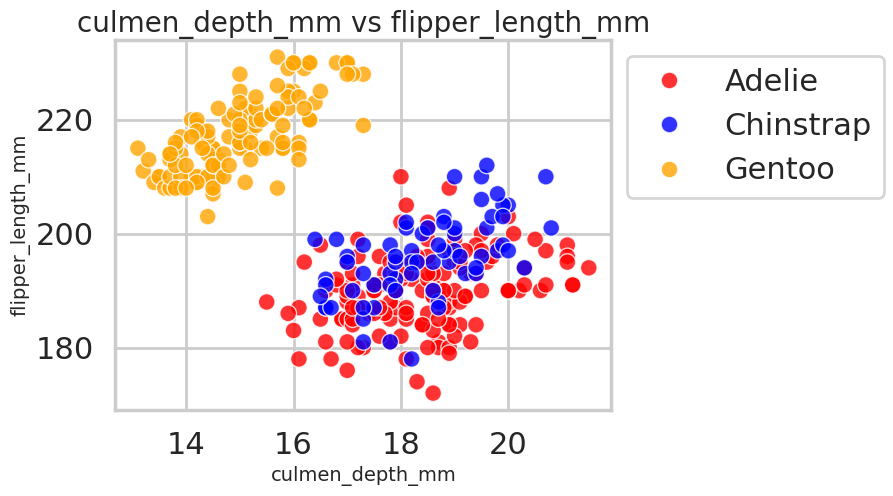

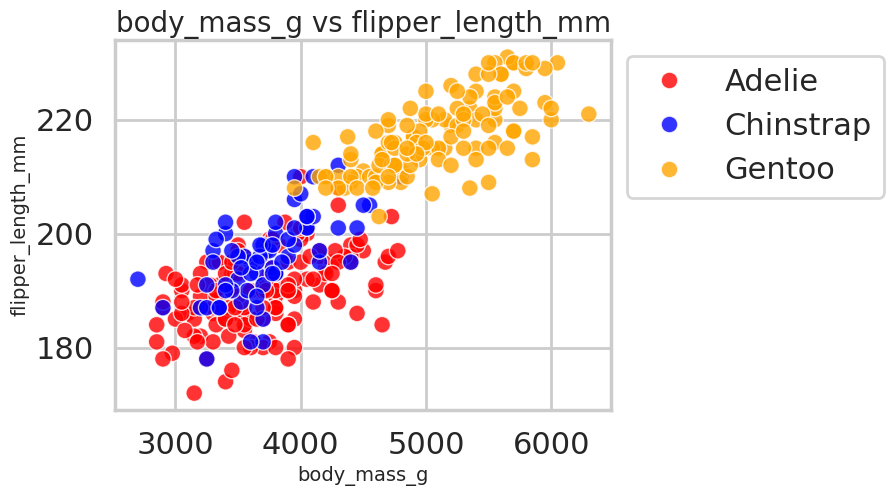

In [2]:
def plot_scatter(feature1, feature2):
  '''
  Provide names of two features to create a scatterplot of them
  E.g. plot_scatter('culmen_length_mm', 'culmen_depth_mm')
  Possible features: 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'
  '''

  palette = ["red", "blue", "orange"]

  sns.scatterplot(data=df_penguins, x = feature1, y = feature2,
               hue = 'species', palette=palette, alpha=0.8)
  # Doc: https://seaborn.pydata.org/generated/seaborn.scatterplot.html

  plt.xlabel(feature1, fontsize=14)
  plt.ylabel(feature2, fontsize=14)
  plt.title(feature1 + ' vs ' + feature2, fontsize=20)
  plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
  plt.show()

# TO DO call plot_scatter with different feature pairs to create some visualizations

plot_scatter('culmen_length_mm', 'flipper_length_mm')
plot_scatter('culmen_depth_mm', 'flipper_length_mm')
plot_scatter('body_mass_g', 'flipper_length_mm')

#### 3b
Suppose you want to be able to identify the Gentoo species with a simple rule with very high accuracy.  Use a decision tree classifier to figure out such a rule that has only two checks (e.g. “mass greater than 4000 g, and culmen length less than 40 mm is Gentoo; otherwise, not”).   You can use the library DecisionTreeClassifier with either ‘gini’ or ‘entropy’ criterion. Use sklearn.tree.plot_tree with feature_names and class_names arguments to visualize the decision tree.  Include the tree that you used to find the rule in your report and the rule.

In [68]:
# TO DO (Train a short tree to identify a good rule, plot the tree, report the rule and its precision/recall in your report)
X, y, feature_names, class_names = get_penguin_xy(df_penguins)
y = 1*(y =='Gentoo')
from sklearn.tree import DecisionTreeClassifier, plot_tree,export_text
from sklearn.metrics import precision_score, recall_score, confusion_matrix
tree = DecisionTreeClassifier(max_depth=2,max_features=1)
tree.fit(X,y)

DecisionTreeClassifier(max_depth=2, max_features=1)

In [72]:
y_pred = tree.predict(X)
print(f"Precision {precision_score(y,y_pred)}")
print(f"Recall {recall_score(y,y_pred)}")
print(f"Acc {(y_pred==y).mean()}")
print(confusion_matrix(y,y_pred))
print(114 / (114+15))
print(114 / (114+8))

Precision 0.8837209302325582
Recall 0.9344262295081968
Acc 0.9325513196480938
[[204  15]
 [  8 114]]
0.8837209302325582
0.9344262295081968


|--- island_torgersen <= 0.50
|   |--- body_mass_g <= 4325.00
|   |   |--- class: Not Gentoo
|   |--- body_mass_g >  4325.00
|   |   |--- class: Gentoo
|--- island_torgersen >  0.50
|   |--- class: Not Gentoo



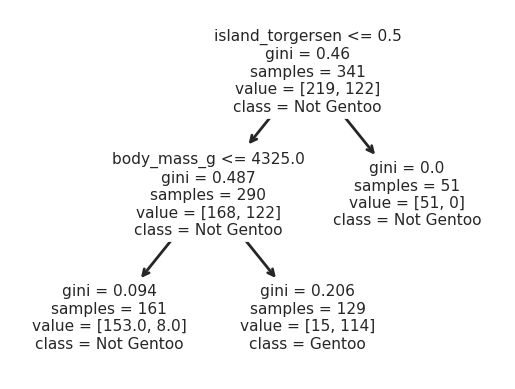

In [70]:
print(export_text(tree, feature_names = feature_names, class_names=['Not Gentoo','Gentoo']))
plot_tree(tree,feature_names=feature_names, class_names=["Not Gentoo", "Gentoo"])
None

#### 3c

Use any method at your disposal to achieve maximum 5-fold cross-validation accuracy on this problem. To keep it simple, we will use sklearn.model_selection to perform the cross-validation for us. Report your model design and 5-fold accuracy.  It is possible to get more than 99% accuracy.

In [76]:
# design a classification model, import libraries as needed
from sklearn.model_selection import cross_val_score

X, y, feature_names, class_names = get_penguin_xy(df_penguins)

# TO DO -- choose some model and fit the data
from sklearn.datasets import load_iris
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

model = GradientBoostingClassifier()


scores = cross_val_score(model, np.array(X), np.array(y), cv=5)
print('CV Accuracy: {}'.format(scores.mean()))

CV Accuracy: 0.9882352941176471


## Part 4: Stretch Goals
Include any new code needed for Part 4 here

# 4a

In [35]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
import torch
import torch.nn as nn

def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data

  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 768-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval

  m = x_train.mean()
  s = x_train.std()
  x_train = (x_train-m)/s
  x_test = (x_test-m)/s
  return (x_train, y_train), (x_test, y_test)

def display_mnist(x, subplot_rows=1, subplot_cols=1):
  '''
  Displays one or more examples in a row or a grid
  '''
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

In [36]:
# Sets device to "cuda" if a GPU is available  (in Colabs, enable GPU by Edit->Notebook Settings-->Hardware Accelerator=GPU)
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device) # make sure you're using GPU instance

cuda


In [37]:
(x_train, y_train), (x_test, y_test) = load_mnist()

# create train/val split
ntrain = 50000
x_val = x_train[ntrain:].copy()
y_val = y_train[ntrain:].copy()
x_train = x_train[:ntrain]
y_train = y_train[:ntrain]
x_val.shape

(10000, 784)

In [38]:
def display_error_curves(training_losses, validation_losses):
  """
  Plots the training and validation loss curves
  training_losses and validation_losses should be lists or arrays of the same length
  """
  num_epochs = len(training_losses)

  plt.plot(range(num_epochs), training_losses, label="Training Loss")
  plt.plot(range(num_epochs), validation_losses, label="Validation Loss")

  # Add in a title and axes labels
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  # Display the plot
  plt.legend(loc='best')
  plt.show()

In [39]:
# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        h1 = 512
        h2 = 256
        self.l1 = nn.Linear(input_size,h1)
        self.l2 = nn.Linear(h1,h2)
        self.l3 = nn.Linear(h2,output_size)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.l1(x))
        x = self.act(self.l2(x))
        x = self.l3(x)
        return x

In [51]:
# This is a possible function definition for training MLP, but feel free to change it
# You may also want to create helper functions, e.g. for computing loss or prediction
def train_MLP_mnist(train_loader, val_loader, lr=1e-1, num_epochs=100):
  '''
  Train a MLP
  Input: train_loader and val_loader are dataloaders for the training and
  val data, respectively. lr is the learning rate, and the network will
  be trained for num_epochs epochs.
  Output: return a trained MLP
  '''
  # TODO: fill in all code

  input_size = 784
  output_size = 10

  # Instantiate the model
  global mlp
  mlp = MLP(input_size,output_size)
  mlp.to(device)
  
  # Train the model, compute and store train/val loss at each epoch
  train_losses,val_losses = [],[]
  optim = torch.optim.SGD(mlp.parameters(),lr=lr)
  for e in range(num_epochs):
    print(f"Epoch: {e}")
    mlp.train()
    tloss, terr = evaluate_MLP(mlp,train_loader,optim)
    mlp.eval()
    vloss, verr = evaluate_MLP(mlp,val_loader,None)
    train_losses.append(tloss)
    val_losses.append(vloss)
    print(f"Terr {100*terr:.2f}   verr {100*verr:.2f}")
    print(f"Tloss {tloss} vloss {vloss}")
    
  
  # Display Loss Curves
  display_error_curves(train_losses,val_losses)
  print(np.min(val_losses), np.argmin(val_losses))
  return mlp


def evaluate_MLP(mlp, loader, optim):
  ''' Computes loss and error rate given your mlp model and data loader'''
  N = 0
  acc = 0
  loss = 0
  loss_function = torch.nn.CrossEntropyLoss()
  with torch.set_grad_enabled(optim is not None):
    for i, data in enumerate(loader, 0):
      # print(i)
      # Get inputs
      inputs, targets = data
      N += len(targets)

      # Perform forward pass
      outputs = mlp(inputs.to(device))

      # Compute sum of correct labels
      y_pred = np.argmax(outputs.detach().cpu().numpy(), axis=1)
      y_gt = np.argmax(targets.numpy(), axis=1)
      acc += np.sum(y_pred==y_gt)

      # Compute loss
      L = loss_function(outputs, targets.to(device))
      if optim:
        optim.zero_grad()
        L.backward()
        optim.step()
      loss += L.item()*len(targets)
      

  loss /= N
  acc /= N

  return loss, 1-acc


In [61]:
# Code for running experiments

print(device) # make sure you're using GPU instance
torch.manual_seed(0) # to avoid randomness, but if you wanted to create an ensemble, you should not use a manual seed

# TODO (set up dataloaders, and call training function)
trainset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(np.eye(10)[y_train]))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

valset = torch.utils.data.TensorDataset(torch.Tensor(x_val), torch.Tensor(np.eye(10)[y_val]))
val_loader = torch.utils.data.DataLoader(valset, batch_size=1000, shuffle=True, num_workers=0)

cuda


In [62]:
testset = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(np.eye(10)[y_test]))
test_loader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True, num_workers=0)

In [63]:
train_MLP_mnist(train_loader,val_loader,0.05)

Epoch: 0
Terr 11.10   verr 5.24
Tloss 0.39561834798812867 vloss 0.18281921446323396
Epoch: 1
Terr 4.77   verr 4.52
Tloss 0.1595677501678467 vloss 0.14803548008203507
Epoch: 2
Terr 3.15   verr 3.02
Tloss 0.10630839919507504 vloss 0.10362636521458626
Epoch: 3
Terr 2.30   verr 2.59
Tloss 0.0775736337813735 vloss 0.08799983635544777
Epoch: 4
Terr 1.64   verr 2.45
Tloss 0.057506488343775274 vloss 0.08281317055225372
Epoch: 5
Terr 1.29   verr 2.18
Tloss 0.04498154129862785 vloss 0.0753883071243763
Epoch: 6
Terr 0.96   verr 2.40
Tloss 0.034889506816864015 vloss 0.07816188521683216
Epoch: 7
Terr 0.67   verr 5.23
Tloss 0.02670353217050433 vloss 0.18872876614332199
Epoch: 8
Terr 0.52   verr 3.63
Tloss 0.02145877429395914 vloss 0.1292068473994732
Epoch: 9
Terr 0.35   verr 2.42
Tloss 0.01578059840232134 vloss 0.08922246024012566
Epoch: 10
Terr 0.23   verr 2.01
Tloss 0.011982590095708146 vloss 0.07129322849214077
Epoch: 11
Terr 0.12   verr 1.91
Tloss 0.0089017694882676 vloss 0.07053324021399021
Epo

KeyboardInterrupt: 

In [67]:
test_loss, test_err = evaluate_MLP(mlp,val_loader,None)
print(test_loss, 100*test_err)

0.07519146390259265 1.6100000000000003


In [ ]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/24SP/hw2" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_SP24_HW2_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")